<a href="https://colab.research.google.com/github/mahapara2411/devopsgit/blob/main/Forecasting_Fbprophet_%2B_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Retail_Dataset.xlsx to Retail_Dataset.xlsx


In [3]:
df = pd.read_excel("Retail_Dataset.xlsx", sheet_name = ["Year 2009-2010", "Year 2010-2011"]) #reading the excel file #reading the excel file

In [5]:
df1 = df["Year 2009-2010"]
df2 = df["Year 2010-2011"]

In [6]:
df = df1.append(df2) #combining the data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
df['Country'].value_counts()

United Kingdom          981330
EIRE                     17866
Germany                  17624
France                   14330
Netherlands               5140
Spain                     3811
Switzerland               3189
Belgium                   3123
Portugal                  2620
Australia                 1913
Channel Islands           1664
Italy                     1534
Norway                    1455
Sweden                    1364
Cyprus                    1176
Finland                   1049
Austria                    938
Denmark                    817
Unspecified                756
Greece                     663
Japan                      582
Poland                     535
USA                        535
United Arab Emirates       500
Israel                     371
Hong Kong                  364
Singapore                  346
Malta                      299
Iceland                    253
Canada                     228
Lithuania                  189
RSA                        169
Bahrain 

In [8]:
data_UK = df[df['Country'] == 'United Kingdom']
data_UK['total_price'] = data_UK['Quantity'] * data_UK['Price']
data_UK['InvoiceDate'] = pd.to_datetime(data_UK['InvoiceDate'])
data_UK['InvoiceDate_15m'] = data_UK['InvoiceDate'].dt.round('15min')
data_UK['InvoiceDate_1h'] = data_UK['InvoiceDate'].dt.round('1h')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [9]:
data_UK.isna().sum()

Invoice                 0
StockCode               0
Description          4382
Quantity                0
InvoiceDate             0
Price                   0
CustomerID         240029
Country                 0
total_price             0
InvoiceDate_15m         0
InvoiceDate_1h          0
dtype: int64

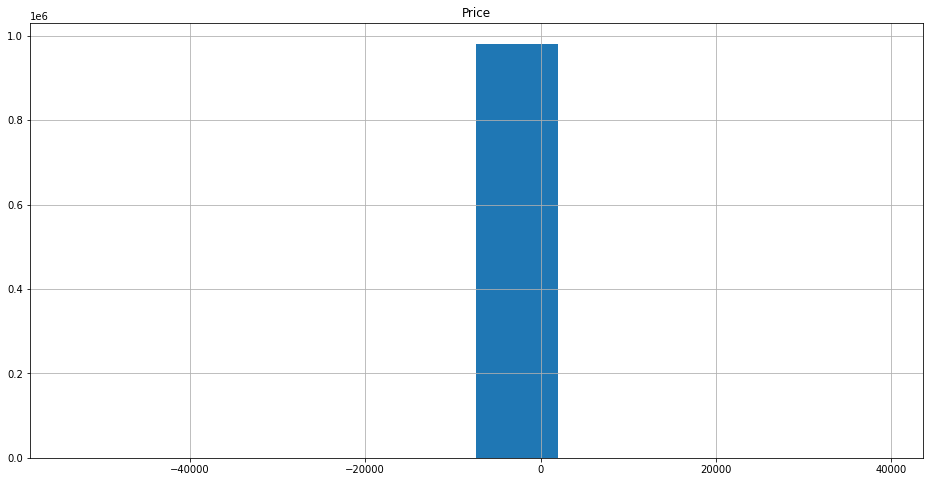

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('Price', ax=ax);

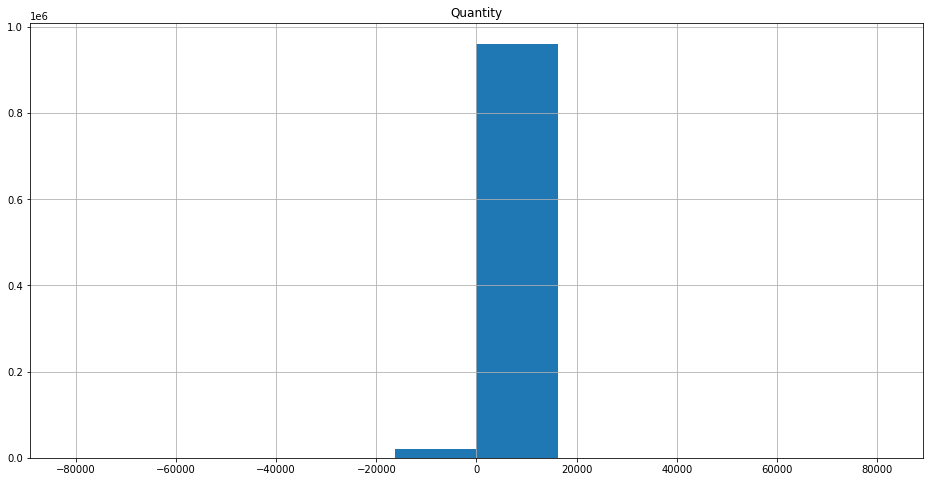

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('Quantity', ax=ax);

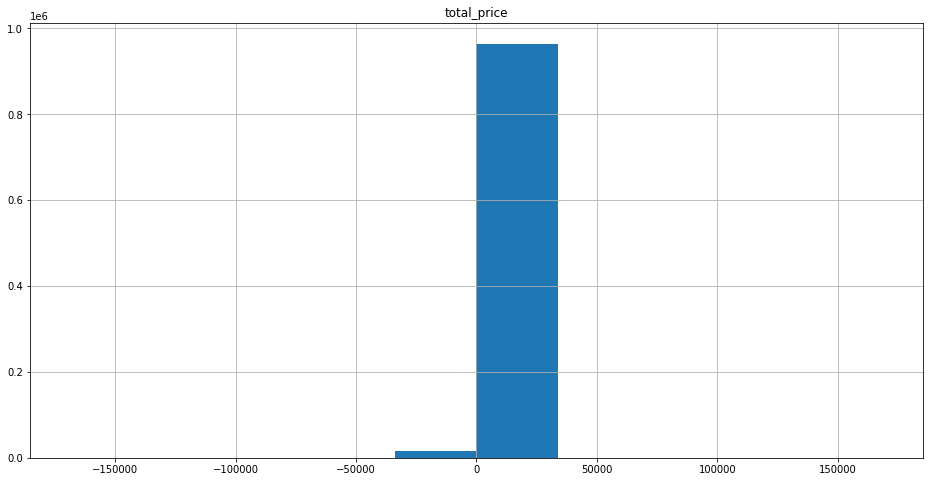

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('total_price', ax=ax);

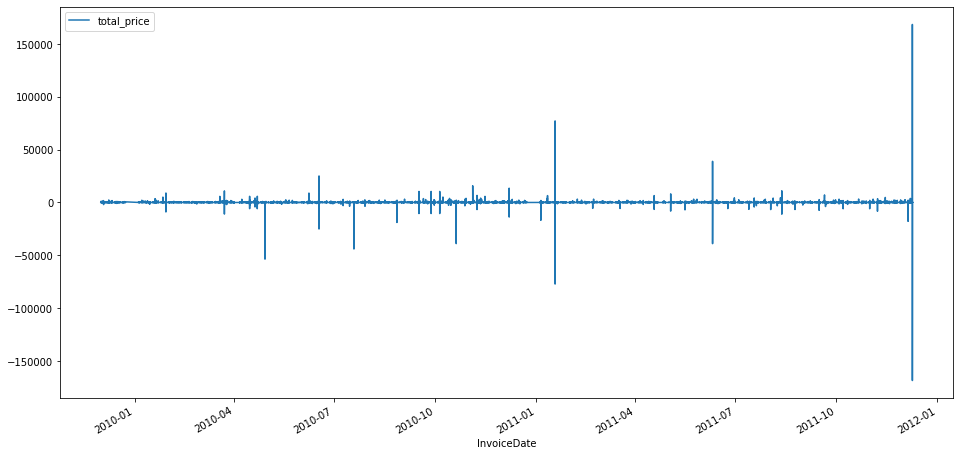

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.plot(x='InvoiceDate', y='total_price', ax=ax);

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


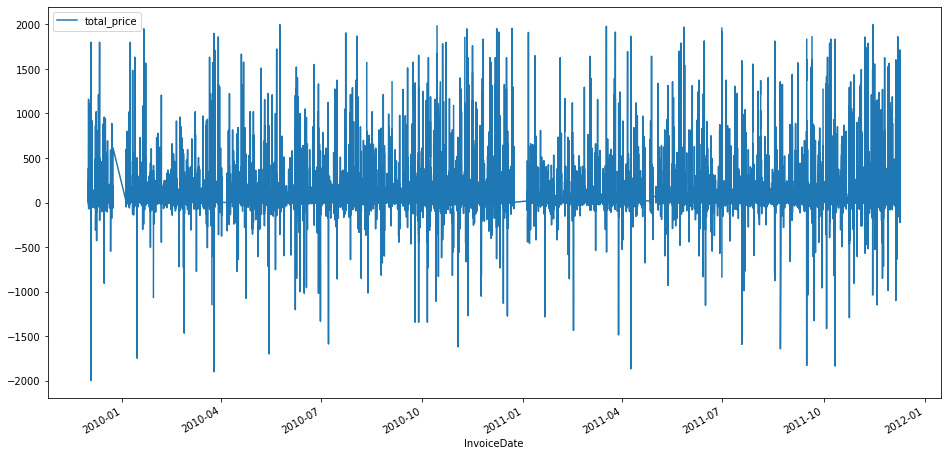

In [14]:
#data_UK = data_UK[(data_UK['total_price'] < 25000) & (data_UK['total_price'] > -25000)]
data_UK.loc[(data_UK['total_price'] > 2000) | (data_UK['total_price'] < -2000), 'total_price'] = None
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.plot(x='InvoiceDate', y='total_price', ax=ax);

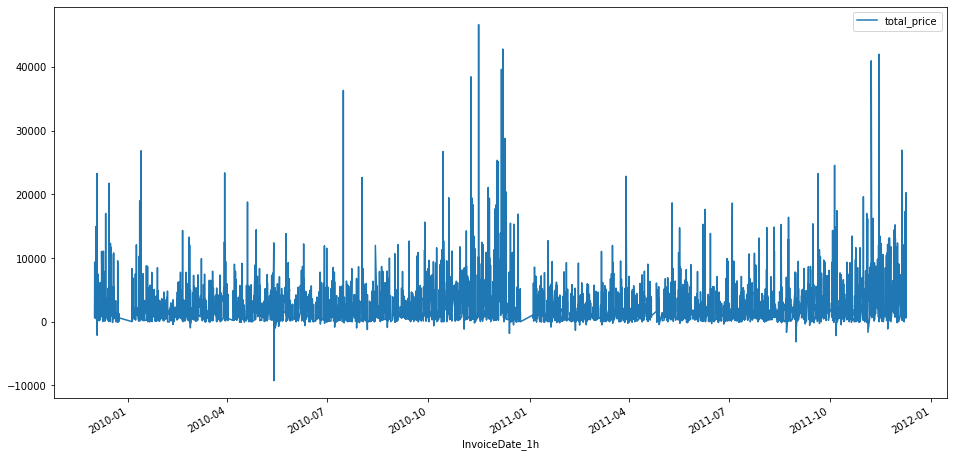

In [15]:
data_UK_1h = data_UK.groupby('InvoiceDate_1h').agg({'total_price':'sum'})
fig, ax = plt.subplots(figsize=(16, 8))
data_UK_1h.plot(y='total_price', ax=ax);

In [16]:
t = np.arange(data_UK_1h.index[0], data_UK_1h.index[-1] + timedelta(hours=1), timedelta(hours=1)).astype(datetime)
train_test = pd.DataFrame()
train_test['ds'] = pd.to_datetime(t)
train_test['y'] = 0
train_test['cap'] = 20000
train_test['floor'] = -2000
train_test.iloc[train_test['ds'].isin(data_UK_1h.index), 1] = data_UK_1h['total_price']
train_test.shape

(17718, 4)

**Hyperparameter Tuning with Optuna**

In [17]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 11.3 MB/s 
     |████████████████████████████████| 209 kB 67.2 MB/s 
     |████████████████████████████████| 81 kB 9.3 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 146 kB 64.4 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 112 kB 42.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=6aa76e5a9d2d28932eb26aed37a7b4924ba4a4dfc2c4ff361fa92f8a5ff436c8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [18]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import optuna

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


test_size = int(train_test.shape[0] / 10)
train_df = train_test.iloc[:-test_size, :]
val_df = train_test.iloc[-test_size:int(-test_size/2), :]
test_df = train_test.iloc[int(-test_size/2):, :]

In [19]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }
    
    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.fit(train_df)
    preds = m.predict(val_df[['ds', 'cap', 'floor']])
    
    mae_score = mean_absolute_error(val_df['y'], preds['yhat'])
    return mae_score

In [20]:
params = {
     'changepoint_prior_scale': 3.391667952710346,
     'changepoint_range': 0.8397114666270911,
     'seasonality_prior_scale': 3.6115808925351867,
     'holidays_prior_scale': 4.845991897188627,
     'seasonality_mode': 'multiplicative',
     'growth': 'linear',
     'weekly_seasonality': 10,
     'yearly_seasonality': 3
}


**Scores of Fbprophet**

In [21]:
def regression_report(y_true, y_pred):
    mae_score = mean_absolute_error(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)
    R2_score = r2_score(y_true, y_pred)
    
    report_dict = {
        'mae_score': mae_score,
        'mse_score': mse_score,
        'r2_score': R2_score
    }
    
    return report_dict

In [22]:
m = Prophet(**params)
m.add_country_holidays(country_name='US')

concat_train_df = pd.concat([train_df, val_df])
m.fit(concat_train_df)
preds = m.predict(test_df[['ds', 'cap', 'floor']])
result = regression_report(test_df['y'], preds['yhat'])

In [23]:
result

{'mae_score': 1243.4361296781474,
 'mse_score': 9125998.656484338,
 'r2_score': 0.37185405044041653}

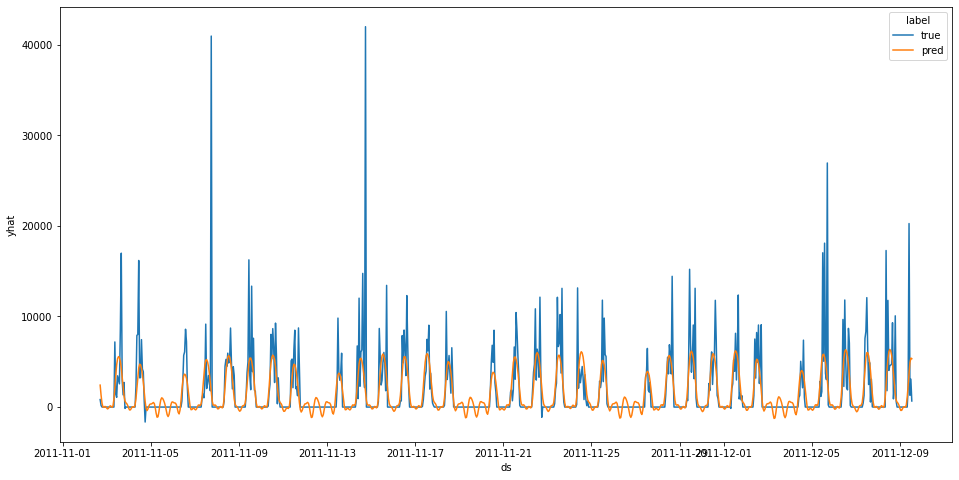

In [24]:
pd.options.mode.chained_assignment = None
test_df.loc[:, 'label'] = 'true'
test_df.loc[:, 'yhat'] = test_df.loc[:, 'y']
preds.loc[:, 'label'] = 'pred'
df_result = pd.concat([test_df[['yhat', 'label', 'ds']], preds[['yhat', 'label', 'ds']]])
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(y='yhat', x='ds', ax=ax, data=df_result, hue='label', markers=True)
plt.show()